# MCMC with Cython

## Performance profiling of Python baseline version

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [2]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [3]:
np.random.seed(123)
data = np.random.randn(20)

In [4]:
%%time
np.random.seed(123)
posterior = sampler(data, samples=1500, mu_init=1.0)
posterior

CPU times: user 5.43 s, sys: 0 ns, total: 5.43 s
Wall time: 5.42 s


In [5]:
def log_sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by adding log probabilities of each data point
        log_likelihood_current = norm(mu_current, 1).logpdf(data).sum()
        log_likelihood_proposal = norm(mu_proposal, 1).logpdf(data).sum()
        
        # Compute prior log probability of current and proposed mu        
        log_prior_current = norm(mu_prior_mu, mu_prior_sd).logpdf(mu_current)
        log_prior_proposal = norm(mu_prior_mu, mu_prior_sd).logpdf(mu_proposal)
        
        log_p_current = log_likelihood_current + log_prior_current
        log_p_proposal = log_likelihood_proposal + log_prior_proposal
        
        # Accept proposal?
        log_p_accept = log_p_proposal - log_p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < np.exp(log_p_accept)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [6]:
%%time
np.random.seed(123)
log_posterior = log_sampler(data, samples=15000, mu_init=1.0)

CPU times: user 5.37 s, sys: 0 ns, total: 5.37 s
Wall time: 5.36 s


In [7]:
np.allclose(posterior, log_posterior)

True

In [8]:
from numpy import pi
def norm_logpdf(mu, sigma, x):
    n = x.shape[0]
    return - n / 2.0 * (np.log(2 * pi) + 2.0 * np.log(sigma)) - (0.5 / sigma**2) * np.sum((x - mu)**2)

In [9]:
norm_logpdf(1.0, 1.0, np.linspace(-1, 3, 1000)), norm(1.0, 1.0).logpdf(np.linspace(-1, 3, 1000)).sum()

(-1586.9398678726741, -1586.9398678726739)

In [10]:
%%timeit x=np.linspace(-1, 3, 1000)
norm_logpdf(1.0, 1.0, x)

11.7 µs ± 202 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
%%timeit x=np.linspace(-1, 3, 1000)
norm(1.0, 1.0).logpdf(x).sum()

841 µs ± 8.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
def log_sampler_v2(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = np.random.normal(mu_current, proposal_width)

        # Compute likelihood by adding log probabilities of each data point
        log_likelihood_current = norm_logpdf(mu_current, 1, data)
        log_likelihood_proposal = norm_logpdf(mu_proposal, 1, data)
        
        # Compute prior log probability of current and proposed mu
        log_prior_current = norm_logpdf(mu_prior_mu, mu_prior_sd, np.array([mu_current]))
        log_prior_proposal = norm_logpdf(mu_prior_mu, mu_prior_sd, np.array([mu_proposal]))
        
        log_p_current = log_likelihood_current + log_prior_current
        log_p_proposal = log_likelihood_proposal + log_prior_proposal
        
        # Accept proposal?
        log_p_accept = log_p_proposal - log_p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < np.exp(log_p_accept)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [13]:
np.random.seed(123)
posterior_v2 = log_sampler_v2(data, samples=1500, mu_init=1.0)
np.random.seed(123)
posterior = log_sampler(data, samples=1500, mu_init=1.0)
np.allclose(posterior_v2, posterior)

True

In [35]:
%%time
np.random.seed(123)
log_posterior = log_sampler_v2(data, samples=15000, mu_init=1.0)

CPU times: user 960 ms, sys: 120 ms, total: 1.08 s
Wall time: 957 ms


In [15]:
%load_ext Cython

In [16]:
%%cython
# cython: profile=True

import numpy as np
cimport numpy as cnp
from numpy import pi

cdef double norm_logpdf(double mu, double sigma, cnp.ndarray[double] x):
    n = x.shape[0]
    return - n / 2.0 * (np.log(2 * pi) + 2.0 * np.log(sigma)) - (0.5 / sigma**2) * np.sum((x - mu)**2)


def log_sampler_cy(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = np.random.normal(mu_current, proposal_width)

        # Compute likelihood by adding log probabilities of each data point
        log_likelihood_current = norm_logpdf(mu_current, 1, data)
        log_likelihood_proposal = norm_logpdf(mu_proposal, 1, data)
        
        # Compute prior log probability of current and proposed mu
        log_prior_current = norm_logpdf(mu_prior_mu, mu_prior_sd, np.array([mu_current]))
        log_prior_proposal = norm_logpdf(mu_prior_mu, mu_prior_sd, np.array([mu_proposal]))
        
        log_p_current = log_likelihood_current + log_prior_current
        log_p_proposal = log_likelihood_proposal + log_prior_proposal
        
        # Accept proposal?
        log_p_accept = log_p_proposal - log_p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < np.exp(log_p_accept)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [17]:
np.random.seed(123)
posterior_v2 = log_sampler_v2(data, samples=15000, mu_init=1.0)
np.random.seed(123)
posterior_cy = log_sampler_cy(data, samples=15000, mu_init=1.0)
np.allclose(posterior_v2, posterior_cy)

True

In [18]:
%%prun
np.random.seed(123)
posterior_cy = log_sampler_cy(data, samples=15000, mu_init=1.0)

In [19]:
%%prun
np.random.seed(123)
posterior_cy = log_sampler_v2(data, samples=15000, mu_init=1.0)

In [20]:
%%cython
# cython: profile=True

from libc.math cimport log as clog, pi as cpi
import numpy as np
cimport numpy as cnp
from numpy import pi

cdef double norm_logpdf(double mu, double sigma, cnp.ndarray[double] x):
    cdef double s = 0.0
    cdef int n = x.shape[0]
    cdef int i
    for i in range(n):
        s += (x[i] - mu)**2
    return - n / 2.0 * (clog(2 * cpi) + 2.0 * clog(sigma)) - (0.5 / sigma / sigma) * s


def log_sampler_cy_v2(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = np.random.normal(mu_current, proposal_width)

        # Compute likelihood by adding log probabilities of each data point
        log_likelihood_current = norm_logpdf(mu_current, 1, data)
        log_likelihood_proposal = norm_logpdf(mu_proposal, 1, data)
        
        # Compute prior log probability of current and proposed mu
        log_prior_current = norm_logpdf(mu_prior_mu, mu_prior_sd, np.array([mu_current]))
        log_prior_proposal = norm_logpdf(mu_prior_mu, mu_prior_sd, np.array([mu_proposal]))
        
        log_p_current = log_likelihood_current + log_prior_current
        log_p_proposal = log_likelihood_proposal + log_prior_proposal
        
        # Accept proposal?
        log_p_accept = log_p_proposal - log_p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < np.exp(log_p_accept)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [21]:
np.random.seed(123)
posterior_v2 = log_sampler_v2(data, samples=15000, mu_init=1.0)
np.random.seed(123)
posterior_cy = log_sampler_cy_v2(data, samples=15000, mu_init=1.0)
np.allclose(posterior_v2, posterior_cy)

True

In [22]:
%%timeit np.random.seed(123)
posterior_cy = log_sampler_cy_v2(data, samples=15000, mu_init=1.0)

119 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%timeit np.random.seed(123)
posterior_cy = log_sampler_cy(data, samples=15000, mu_init=1.0)

782 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%cython -a
# cython: profile=True

DEF LOG_2_PI = 1.8378770664093453

cimport cython
from libc.math cimport log as clog, pi as cpi, exp as cexp
import numpy as np
cimport numpy as cnp
from numpy import pi

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef double norm_logpdf(const double mu, const double sigma, const double* const x, const int n):
    cdef double s = 0.0
    cdef double ONE_OVER_SIG = 1.0 / sigma
    cdef int i
    for i in range(n):
        s += (x[i] - mu) * (x[i] - mu)
    return - 0.5 * n * LOG_2_PI - n * clog(sigma) - 0.5 * ONE_OVER_SIG * ONE_OVER_SIG * s

cdef double sample_norm(double mu, double sigma):
    return np.random.normal(mu, sigma)

cdef bint accept_p(double log_p_accept):
    return np.random.rand() < cexp(log_p_accept)

@cython.boundscheck(False)
@cython.wraparound(False)
def log_sampler_cy_v3(cnp.ndarray[double] data,
                      int samples,
                      double mu_init=.5,
                      double proposal_width=.5,
                      double mu_prior_mu=0,
                      double mu_prior_sd=1.):
    
    cdef:
        double mu_proposal, log_likelihood_current, log_likelihood_proposal
        double log_prior_current, log_prior_proposal
        double log_p_current, log_p_proposal
        double log_p_accept
        bint accept
        double mu_current = mu_init
        list posterior = [mu_current]
        int i
        double *cdata = &data[0]
        int ndata = data.shape[0]
        cnp.ndarray[double] np_buf = np.empty((1,), dtype='f8')
        double *buf1 = &np_buf[0]
        
        
    for i in range(samples):
        # suggest new position
        mu_proposal = sample_norm(mu_current, proposal_width)

        # Compute likelihood by adding log probabilities of each data point
        log_likelihood_current = norm_logpdf(mu_current, 1, cdata, ndata)
        log_likelihood_proposal = norm_logpdf(mu_proposal, 1, cdata, ndata)
        
        # Compute prior log probability of current and proposed mu
        buf1[0] = mu_current
        log_prior_current = norm_logpdf(mu_prior_mu, mu_prior_sd, buf1, 1)
        buf1[0] = mu_proposal
        log_prior_proposal = norm_logpdf(mu_prior_mu, mu_prior_sd, buf1, 1)
        
        log_p_current = log_likelihood_current + log_prior_current
        log_p_proposal = log_likelihood_proposal + log_prior_proposal
        
        # Accept proposal?
        log_p_accept = log_p_proposal - log_p_current
        
        if accept_p(log_p_accept):
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [25]:
%%prun
np.random.seed(123)
posterior_cy = log_sampler_cy_v3(data, samples=15000, mu_init=1.0)

In [26]:
%%timeit np.random.seed(123)
posterior_cy = log_sampler_cy_v3(data, samples=15000, mu_init=1.0)

38.4 ms ± 441 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
np.random.seed(123)
posterior_v2 = log_sampler_v2(data, samples=15000, mu_init=1.0)
np.random.seed(123)
posterior_v3 = log_sampler_cy_v3(data, samples=15000, mu_init=1.0)
np.allclose(posterior_v2, posterior_v3)

True

In [30]:
cd cython_mcmc

/home/jovyan/cython_mcmc


In [31]:
from cython_mcmc import mcmc

In [34]:
%%timeit
posterior_v3_mcmc = mcmc.log_sampler_cy_v3(data, samples=15000, mu_init=1.0)

6.55 ms ± 68 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
%%prun
posterior_v3_mcmc = mcmc.log_sampler_cy_v3(data, samples=15000, mu_init=1.0)

```
        90005 function calls in 0.484 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.240    0.240    0.483    0.483 mcmc.pyx:36(log_sampler_cy_v3)
    60000    0.156    0.000    0.156    0.000 mcmc.pyx:15(norm_logpdf)
    15000    0.044    0.000    0.044    0.000 mcmc.pyx:31(accept_p)
    15000    0.043    0.000    0.043    0.000 mcmc.pyx:25(sample_norm_v2)
```

In [48]:
%%timeit
posterior_v3 = log_sampler_cy_v3(data, samples=15000, mu_init=1.0)

37 ms ± 797 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%%prun
posterior_v3 = log_sampler_cy_v3(data, samples=15000, mu_init=1.0)

```
       90005 function calls in 0.535 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.245    0.245    0.535    0.535 _cython_magic_5f77bd24bb31d4a93b913436028fc4b9.pyx:30(log_sampler_cy_v3)
    60000    0.156    0.000    0.156    0.000 _cython_magic_5f77bd24bb31d4a93b913436028fc4b9.pyx:14(norm_logpdf)
    15000    0.081    0.000    0.081    0.000 _cython_magic_5f77bd24bb31d4a93b913436028fc4b9.pyx:22(sample_norm)
    15000    0.053    0.000    0.053    0.000 _cython_magic_5f77bd24bb31d4a93b913436028fc4b9.pyx:25(accept_p)
```

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

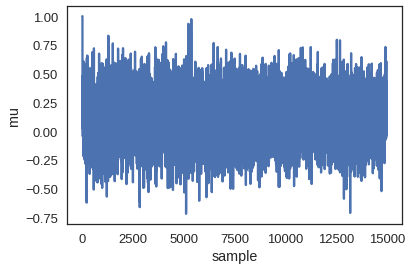

In [38]:
fig, ax = plt.subplots()
ax.plot(posterior_v3_mcmc)
_ = ax.set(xlabel='sample', ylabel='mu');

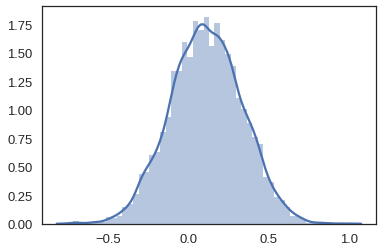

In [44]:
ax = plt.subplot()
sns.distplot(posterior_v3_mcmc[500:], ax=ax, label='estimated posterior')